(psychophysics_group_level)=
# Fitting a psychometric function at the group level

Author: Nicolas Legrand <nicolas.legrand@cas.au.dk>

In [1]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import pymc as pm

sns.set_context('talk')

In this example, we are going to fit a cummulative normal function to decision responses made during the Heart Rate Discrimination task. We will use the data from the [HRD method paper](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) {cite:p}`2022:legrand` and analyse the responses from all participants and infer group-level hyperpriors.

In [2]:
# Load data frame
psychophysics_df = pd.read_csv('https://github.com/LegrandNico/CardioceptionPaper/raw/main/data/Del2_merged.txt')

First, let's filter this data frame so we only keep the interoceptive condition (`Extero` label).

In [3]:
this_df = psychophysics_df[psychophysics_df.Modality == 'Extero']
this_df.head()

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier,Subject
1,psi,Less,Extero,psi,Less,2.216429,59.0,1.632995,-0.5,78.0,...,22.805550,12.549457,1.603353e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
3,psiCatchTrial,Less,Extero,psiCatchTrial,Less,1.449154,100.0,0.511938,-30.0,82.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
6,psi,More,Extero,psi,More,1.182666,95.0,0.606786,22.5,69.0,...,10.001882,12.884902,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
10,psi,More,Extero,psi,More,1.848141,24.0,1.448969,10.5,62.0,...,0.998384,13.044744,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
11,psiCatchTrial,More,Extero,psiCatchTrial,More,1.349469,75.0,0.561820,10.0,72.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019


This data frame contain a large number of columns, but here we will be interested in the `Alpha` column (the intensity value) and the `Decision` column (the response made by the participant).

In [4]:
this_df = this_df[['Alpha', 'Decision', 'Subject']]
this_df.head()

,Alpha,Decision,Subject
1,-0.5,Less,sub_0019
3,-30.0,Less,sub_0019
6,22.5,More,sub_0019
10,10.5,More,sub_0019
11,10.0,More,sub_0019


These two columns are enought for us to extract the 3 vectors of interest to fit a psychometric function:
* The intensity vector, listing all the tested intensities values
* The total number of trials for each tested intensity value
* The number of "correct" response (here, when the decision == 'More').

Let's take a look at the data. This function will plot the proportion of "Faster" responses depending on the intensity value of the trial stimuli (expressed in BPM). Here, the size of the circle represent the number of trials that were presented for each intensity values.

# Model

The model is defined as follows:

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \Phi_{i, j}(x_{i, j}, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i, j} - \alpha}{\beta * \sqrt{2}})$$
$$ \alpha_{i} \sim \mathcal{Normal}(\mu_{\alpha}, \sigma_{\alpha})$$
$$ \beta_{i} \sim \mathcal{Normal}(\mu_{\beta}, \sigma_{\beta})$$

$$ \mu_{\alpha} \sim  \mathcal{Uniform}(-50, 50)$$
$$ \sigma_{\alpha} \sim  |\mathcal{Normal}(0, 100)|$$

$$ \mu_{\beta} \sim  \mathcal{Uniform}(0, 100)$$
$$ \sigma_{\beta} \sim  |\mathcal{Normal}(0, 100)|$$


Where $erf$ is the [error functions](https://en.wikipedia.org/wiki/Error_function), and $\Phi$ is the cumulative normal function with threshold $\alpha$ and slope $\beta$.

We create our own cumulative normal distribution function here using pytensor.

In [5]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * pt.erf((x - alpha) / (beta * pt.sqrt(2)))

We preprocess the data to extract the intensity $x$, the number or trials $n$ and number of hit responses $r$. We also create a vector `sub_total` containing the participants index (from 0 to $n_{participants}$).



In [6]:
nsubj = this_df.Subject.nunique()
x_total, n_total, r_total, sub_total = [], [], [], []

for i, sub in enumerate(this_df.Subject.unique()):

    sub_df = this_df[this_df.Subject==sub]

    x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

    for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
        x[ii] = intensity
        n[ii] = sum(sub_df.Alpha == intensity)
        r[ii] = sum((sub_df.Alpha == intensity) & (sub_df.Decision == "More"))

    # remove no responses trials
    validmask = n != 0
    xij, nij, rij = x[validmask], n[validmask], r[validmask]
    sub_vec = [i] * len(xij)

    x_total.extend(xij)
    n_total.extend(nij)
    r_total.extend(rij)
    sub_total.extend(sub_vec)

Create the model.

In [7]:
with pm.Model() as group_psychophysics:

    mu_alpha = pm.Uniform("mu_alpha", lower=-50, upper=50)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

    mu_beta = pm.Uniform("mu_beta", lower=0, upper=100)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=nsubj)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=nsubj)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total])
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)

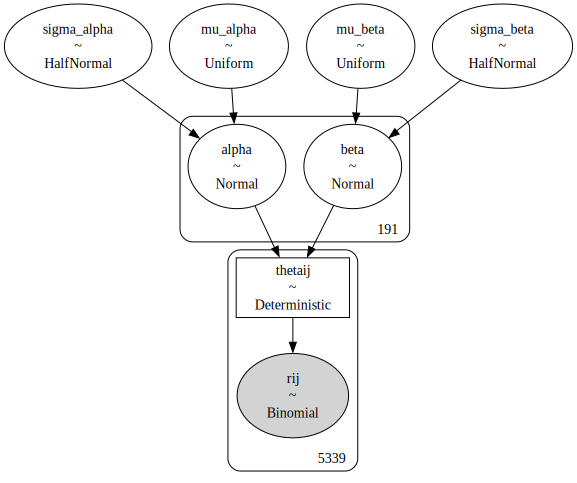

In [8]:
pm.model_to_graphviz(group_psychophysics)

Sampling.

In [9]:
with group_psychophysics:
    idata = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


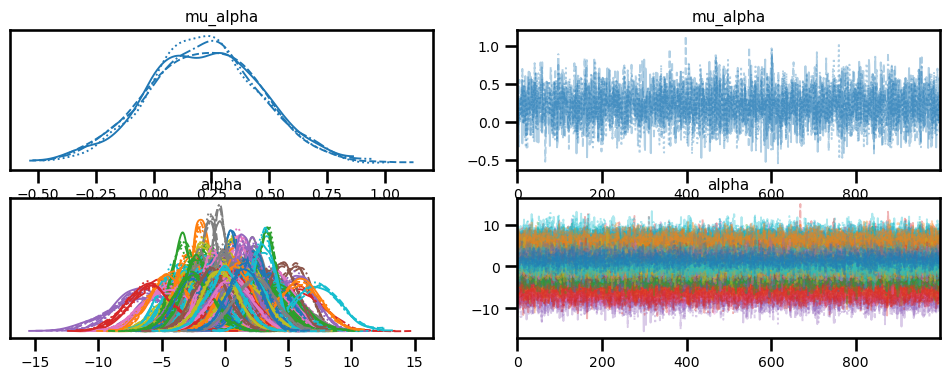

In [10]:
az.plot_trace(idata, var_names=["mu_alpha", "alpha"]);

In [11]:
stats = az.summary(idata, var_names=["mu_alpha", "mu_beta"])
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,0.218,0.241,-0.224,0.691,0.004,0.003,4670.0,3227.0,1.0
mu_beta,7.926,0.233,7.516,8.370,0.004,0.003,2931.0,2961.0,1.0


```{hint}Here, $\alpha$ refers to the threshold value (also the point of subjective equality for this design). We can observe that the group of participants has an average threshold very close to 0 and a slope of 7, which is relatively small in this context and indicates a precise decision process. A higher value means lower precision. By looking at the posterior density of the threshold ($\alpha$), we can see that the 94% highest density interval (HDI) includes 0, suggesting that we have good evidence that no bias can be observed at the group level for the exteroceptive condition.
```

<Axes: title={'center': 'mu_alpha'}>

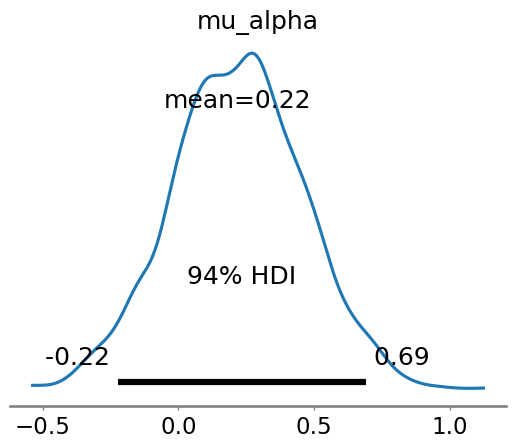

In [12]:
az.plot_posterior(idata, var_names=["mu_alpha"])

# Plotting
Extrace the individual parameters estimates.

In [13]:
alpha_samples = az.summary(idata, var_names=["alpha"])["mean"].values
beta_samples = az.summary(idata, var_names=["beta"])["mean"].values

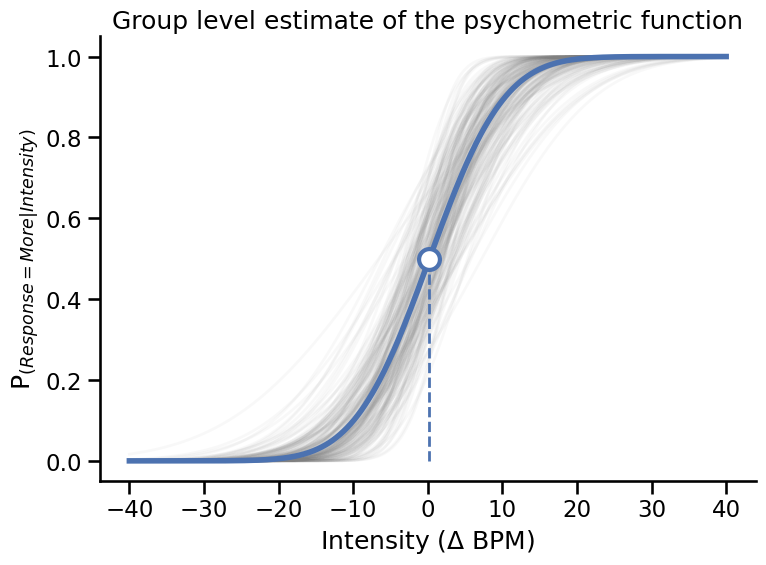

In [14]:
fig, axs = plt.subplots(figsize=(8, 6))

# Draw some sample from the traces
for a, b in zip(alpha_samples, beta_samples):
    axs.plot(
        np.linspace(-40, 40, 500), 
        (norm.cdf(np.linspace(-40, 40, 500), loc=a, scale=b)),
        color='gray', alpha=.05, linewidth=2
    )

# Plot psychometric function with average parameters
slope = az.summary(idata, var_names=["mu_beta"])['mean']['mu_beta']
threshold = az.summary(idata, var_names=["mu_alpha"])['mean']['mu_alpha']
axs.plot(np.linspace(-40, 40, 500), 
        (norm.cdf(np.linspace(-40, 40, 500), loc=threshold, scale=slope)),
         color='#4c72b0', linewidth=4)

axs.plot([threshold, threshold], [0, .5], '--', color='#4c72b0', linewidth=2)
axs.plot(threshold, .5, 'o', color='w', markeredgecolor='#4c72b0', 
         markersize=15, markeredgewidth=3)

plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.title('Group level estimate of the psychometric function')
plt.tight_layout()
sns.despine()

## System configuration

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,arviz,pytensor

Last updated: Wed Jun 28 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pymc    : 5.5.0
arviz   : 0.15.1
pytensor: 2.12.3

numpy     : 1.24.4
matplotlib: 3.7.1
arviz     : 0.15.1
seaborn   : 0.12.2
pymc      : 5.5.0
pandas    : 2.0.2
pytensor  : 2.12.3

Watermark: 2.4.2

